# Explore Markov Chain model of decay of IBD curves over time
MC: Markov Chain

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import socket as socket
import os as os
import sys as sys
import h5py
import matplotlib.cm as cm
import itertools as it
import multiprocessing as mp

socket_name = socket.gethostname()
print(socket_name)

if socket_name.startswith("bionc") or socket_name.startswith("hpc"):
    print("Leipzig Cluster detected!")
    path = "/mnt/archgen/users/hringbauer/"
    #sys.path.append("/mnt/archgen/users/hringbauer/git/hapBLOCK/python3/")
    #sys.path.insert(0, "/mnt/archgen/users/hringbauer/git/hapBLOCK/package/")
else: 
    raise RuntimeWarning("Not compatible machine. Check!!")

os.chdir(path)  # Set the right Path (in line with Atom default)
print(os.getcwd())
print(f"CPU Count: {mp.cpu_count()}")

### Imports for this project
from scipy.sparse import diags
from scipy.sparse.linalg import expm_multiply

%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}

hpc030
Leipzig Cluster detected!
/mnt/archgen/users/hringbauer
CPU Count: 128


In [259]:
### Transition Matrix Harald way

def get_q_mat(x):
    """Get infinitesimal transition matrix.
    x: List of bins (edges). In Morgan."""
    n = len(x)
    w = x[1]-x[0] # Width of one Bin
    q = np.ones((n,n)) *w
    q = np.tril(q, k=-1)
    v = -np.sum(q, axis=1)
    np.fill_diagonal(q,v)
    return q

def get_q_mat1(x):
    """Get infinitesimal transition matrix.
    x: List of bins (edges). In Morgan."""
    n = len(x)
    w = x[1]-x[0] # Width of one Bin
    q = np.ones((n,n)) *2*w
    q = np.tril(q, k=-1)
    v = -np.sum(q, axis=1)/2 + w
    np.fill_diagonal(q,v)
    return q

def get_q_mat_cpt(x):
    # Construct Q with chatpt instructions
    # Warning: BUG
    n = len(x)
    w = x[1]-x[0] # Width of one Bin
    lower = np.full(n-1, 2*w)
    diagonal = -w * np.arange(n) + w
    q = diags([lower, diagonal], offsets=[-1, 0])
    return q

In [14]:
x = np.linspace(0,19,191)/100 # Morgan Grid
q = get_q_mat(x)

## Calculate the Transition Matrix
Compute p(t) for all t in t_list

In [184]:
%%time
# Initialize Condition P0
p0 = np.zeros(len(x))
### For Uniform P0
k=len(p0) 
p0[-k:] = 1/k

### Calculate the time point probs
t_list = np.linspace(0, 10, 100) # Time points

P = expm_multiply(q.T, p0, start=0, stop=100, num=100)

CPU times: user 72.7 ms, sys: 1.77 ms, total: 74.5 ms
Wall time: 72.3 ms


### Plots of state evolution
Plot histograms

In [ ]:
np.sum(P, axis=1)

In [ ]:
x

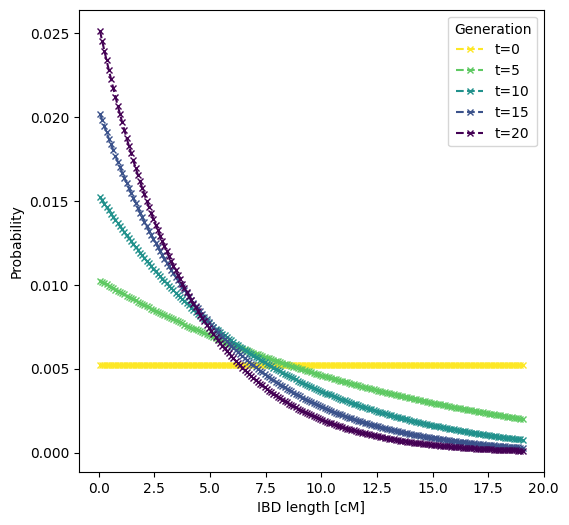

In [195]:
#x =-v*100 # x Axis (converted to cM)
x_plot = x * 100 # Convert to Morgan
t_plot = [0,5,10,15,20]
c_plot = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154"]

plt.figure(figsize=(6,6))
ax = plt.gca()
for t,c in zip(t_plot, c_plot):
    #ax.bar(x+x[1]/2, P[t,:], width=x[1], color=c, edgecolor="k", label=f"t={t}", alpha=0.8)
    ax.plot(x_plot+x_plot[1]/2, P[t,:], color=c, label=f"t={t}", alpha=1.0, ls="--", marker="x", ms=5)

ax.legend(loc="upper right", title="Generation")
ax.set_ylabel("Probability")
ax.set_xlabel("IBD length [cM]")
#ax.set_yscale("log")
plt.show()

# 2) Compare Calculations to Simulations
Simulations are run in `./sim_timedelta_msprime.ipynb`

### Load Simulations

In [177]:
def produce_ind_ibd_dfs_reps(loadfolder = "./git/hapBLOCK/output/deltaTsim/ne500_00/", 
                             nes = [500], reps = 10, inds = 50):
    """Load Individual IBD dataframes across replicates and post-process them.
    Return master dataframe of all IBD segments."""

    df_ibds, iids, pops = produce_ind_roh_dfs(loadfolder = loadfolder,
                        nes = nes, reps = reps, inds = inds)

    df_ibd = pd.concat(df_ibds)
    print(f"Found {len(df_ibd)} IBD segments in {len(iids)} haplotype pairs")
    
    df_ibd["ind"] = "rep_" + df_ibd["replicate"].astype("str")
    df_ibd["iid1"] = df_ibd["ind"]
    df_ibd["iid2"] = df_ibd["ind"]
    return df_ibd

def produce_ind_roh_dfs(loadfolder = "./Simulated/msprime/fixed_Ne_gaps_merged/",
                        nes = [250, 500, 1000, 2000], reps = 10, inds = 10):
    """Return list of individual ROH dfs. Splits up replicate individuals and
    assigns individuals iids
    nes: Diploid population size estimates
    reps: How many replicates.
    inds: How many individuals"""
    df_rohs = []
    iids, pops = [], []
    
    for ne_dip in nes:
        iid = 0    
        for r in range(reps):
            loadpath = loadfolder + str(ne_dip) + "_" + str(r) + ".tsv" 
            df_load = pd.read_csv(loadpath, sep="\t")
            for ind in range(inds):
                df_t = df_load[df_load["replicate"]==ind]
                df_rohs.append(df_t)
                iids.append(f"rep_{iid}")
                iid+=1
                pops.append("2Ne_" + str(ne_dip*2))
    return df_rohs, iids, pops

def get_ibd_sharing_prob(df_ibd, bins, n_pairs=1):
    """Get the probability of pw. IBD sharing in length bins.
    Return count matrix.
    df_ibd: Standard IBD dataframe (1 IBD segment per row) with lengthM column
    bins: Bins in Morgan
    n_pairs: Number of pairwise comparisons"""
    hist, _ = np.histogram(df_ibd["lengthM"], bins=bins)
    pr = hist/n_pairs
    return pr

In [178]:
dts = [0,10,20,30,40,50]
x1=np.linspace(0,250,251)*0.01

df_ibds = [produce_ind_ibd_dfs_reps(loadfolder = f"./git/hapBLOCK/output/deltaTsim/ne500_00_d{dt}/", 
                                     nes = [500], reps = 10, inds = 100) for dt in dts] 
y = np.array([get_ibd_sharing_prob(df_ibd,x1,n_pairs=1000) for df_ibd in df_ibds])

Found 10963 IBD segments in 1000 haplotype pairs
Found 10257 IBD segments in 1000 haplotype pairs
Found 8890 IBD segments in 1000 haplotype pairs
Found 7333 IBD segments in 1000 haplotype pairs
Found 5852 IBD segments in 1000 haplotype pairs
Found 4536 IBD segments in 1000 haplotype pairs


In [179]:
np.shape(y)

(6, 250)

### Plot Decay with dt

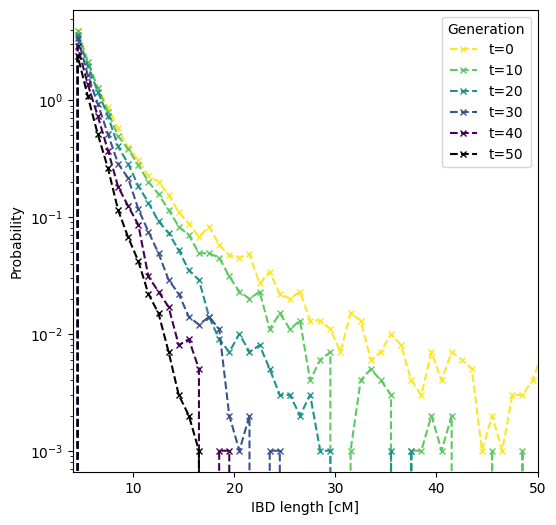

In [180]:
#x =-v*100 # x Axis (converted to cM)
x_plot = x1[:-1] * 100 # Convert to Morgan
t_plot = dts
c_plot = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154", "k"]

plt.figure(figsize=(6,6))
ax = plt.gca()
for i in range(len(y)):
    ax.plot(x_plot+x_plot[1]/2, y[i,:], color=c_plot[i], label=f"t={t_plot[i]}", alpha=1.0, ls="--", marker="x", ms=5)

ax.legend(loc="upper right", title="Generation")
ax.set_ylabel("Probability")
ax.set_xlabel("IBD length [cM]")
ax.set_yscale("log")

ax.set_xlim([4,50])
plt.show()

## 2b) Caculate with rate Matrix

In [192]:
q1 = get_q_mat1(x1)
q1=q1[:250,:250]

In [193]:
q1

array([[ 0.01,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.02,  0.02, -0.01, ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.02,  0.02,  0.02, ..., -2.46,  0.  ,  0.  ],
       [ 0.02,  0.02,  0.02, ...,  0.02, -2.47,  0.  ],
       [ 0.02,  0.02,  0.02, ...,  0.02,  0.02, -2.48]], shape=(250, 250))

In [194]:
%%time
p0 = y[0,:]

### Calculate the time point probs
#t_list = np.linspace(0, 100, 100) # Time points

P = expm_multiply(q1.T, p0, start=0, stop=50, num=6, endpoint=True)

CPU times: user 61.8 ms, sys: 0 ns, total: 61.8 ms
Wall time: 59.7 ms


In [185]:
np.shape(P)

(6, 250)

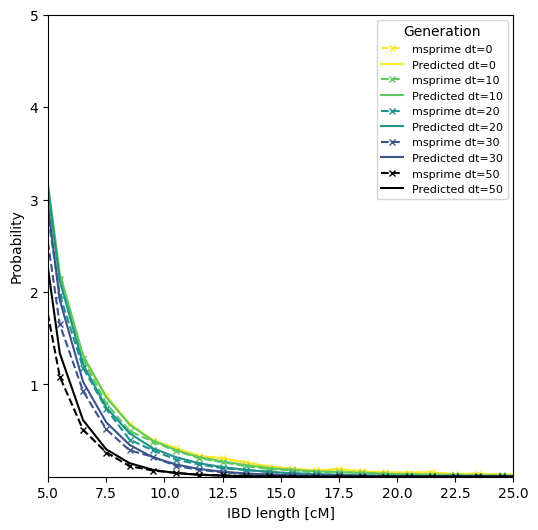

In [196]:
#x =-v*100 # x Axis (converted to cM)
x_plot = x1[:-1] * 100 # Convert to Morgan
t_plot = [0,1,2,3,5]
c_plot = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154", "k"]
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()
for i in t_plot:
    ax.plot(x_plot+x_plot[1]/2, y[i,:], color=c_plot[i], label=f"msprime dt={i*10}", alpha=1.0, ls="--", marker="x", ms=5)

    ax.plot(x_plot+x_plot[1]/2, P[i,:], color=c_plot[i], label=f"Predicted dt={i*10}", alpha=1.0, ls="-", marker="", ms=5)

ax.legend(loc="upper right", title="Generation", fontsize=8)
ax.set_ylabel("Probability")
ax.set_xlabel("IBD length [cM]")
#ax.set_yscale("log")

ax.set_xlim([5,25])
ax.set_ylim([0.0001,5])

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")


plt.show()

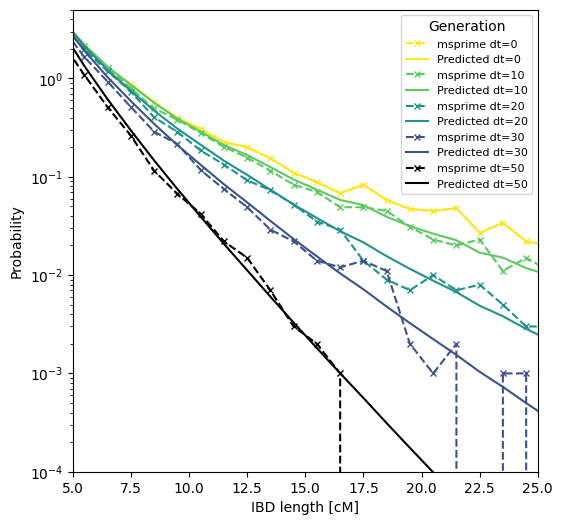

In [198]:
#x =-v*100 # x Axis (converted to cM)
x_plot = x1[:-1] * 100 # Convert to Morgan
t_plot = [0,1,2,3,5]
c_plot = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154", "k"]
savepath=""

plt.figure(figsize=(6,6))
ax = plt.gca()
for i in t_plot:
    ax.plot(x_plot+x_plot[1]/2, y[i,:], color=c_plot[i], label=f"msprime dt={i*10}", alpha=1.0, ls="--", marker="x", ms=5)

    ax.plot(x_plot+x_plot[1]/2, P[i,:], color=c_plot[i], label=f"Predicted dt={i*10}", alpha=1.0, ls="-", marker="", ms=5)

ax.legend(loc="upper right", title="Generation", fontsize=8)
ax.set_ylabel("Probability")
ax.set_xlabel("IBD length [cM]")
ax.set_yscale("log")

ax.set_xlim([5,25])
ax.set_ylim([0.0001,5])

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")


plt.show()

# Do the fine-scale Calculations
Use 0.1cm bins

In [244]:
dts = [0,10,20,30,40,50] # Vector of time differences
x1=np.linspace(0,250,2501)*0.01 # in 0.1cm bins

df_ibds = [produce_ind_ibd_dfs_reps(loadfolder = f"./git/hapBLOCK/output/deltaTsim/ne500_00_d{dt}/", 
                                     nes = [500], reps = 10, inds = 100) for dt in dts] 
y = np.array([get_ibd_sharing_prob(df_ibd,x1,n_pairs=1000) for df_ibd in df_ibds])

Found 10963 IBD segments in 1000 haplotype pairs
Found 10257 IBD segments in 1000 haplotype pairs
Found 8890 IBD segments in 1000 haplotype pairs
Found 7333 IBD segments in 1000 haplotype pairs
Found 5852 IBD segments in 1000 haplotype pairs
Found 4536 IBD segments in 1000 haplotype pairs


In [256]:
%%time
### Initial Condition: Observation at dt=0
p0 = y[0,:]

### Get the rate Matrix
q1 = get_q_mat1(x1)
q1=q1[:2500,:2500]

#q1 = get_q_mat_cpt(x1[:-1])


### Calculate the time point probs
#t_list = np.linspace(0, 100, 100) # Time points

P = expm_multiply(q1.T, p0, start=0, stop=50, num=6, endpoint=True)

CPU times: user 10.7 s, sys: 50.3 ms, total: 10.8 s
Wall time: 289 ms


In [257]:
### Add bins of 10 length bins (0.1 ->1cm bins here)
y10 = y.reshape(y.shape[0],-1, 10).sum(axis=2)
P10 = P.reshape(P.shape[0],-1, 10).sum(axis=2)

Saved to ./git/hapBLOCK/figs/dt_sims/df_sim_ne500_r10_ind100_dt0-50.pdf


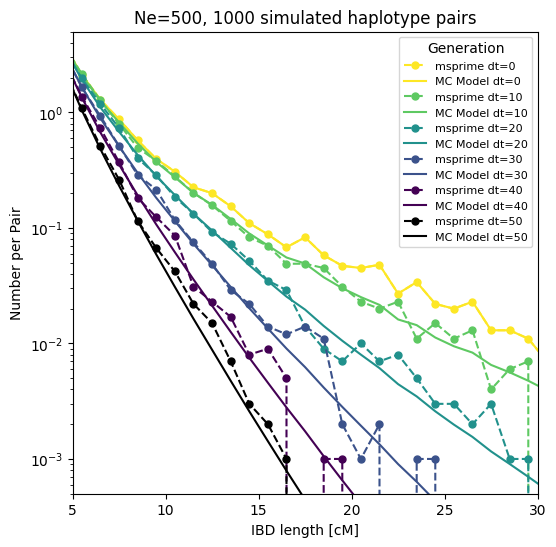

In [258]:
#x =-v*100 # x Axis (converted to cM)
x_plot = x1[:-1:10] * 100 # Convert to Morgan
t_plot = [0,1,2,3,4,5]
c_plot = ["#fde725", "#5ec962", "#21918c", "#3b528b", "#440154", "k"]
savepath="./git/hapBLOCK/figs/dt_sims/df_sim_ne500_r10_ind100_dt0-50.pdf"

plt.figure(figsize=(6,6))
ax = plt.gca()
for i in t_plot:
    ax.plot(x_plot+x_plot[1]/2, y10[i,:], c=c_plot[i], 
            label=f"msprime dt={i*10}", ls="--", marker="o", ms=5)

    ax.plot(x_plot+x_plot[1]/2, P10[i,:], c=c_plot[i], 
            label=f"MC Model dt={i*10}", ls="-", marker="", ms=5)

ax.legend(loc="upper right", title="Generation", fontsize=8)
ax.set_ylabel("Number per Pair")
ax.set_xlabel("IBD length [cM]")
ax.set_yscale("log")

ax.set_xlim([5,30])
ax.set_ylim([0.0005,5])
ax.set_title("Ne=500, 1000 simulated haplotype pairs")

if len(savepath)>0:
    plt.savefig(savepath, bbox_inches ='tight', pad_inches = 0, dpi=400)
    print(f"Saved to {savepath}")


plt.show()

# Area 51

### Suggestion Q Matrix ChatGPT

In [201]:
%%time
p0 = y[0,:]

### Calculate the time point probs
#t_list = np.linspace(0, 100, 100) # Time points

P = expm_multiply(q1.T, p0, start=0, stop=50, num=6, endpoint=True)

ValueError: shapes of matrices A (250, 250) and B (2500,) are incompatible